# This notebook implements Deep learning techniques for a particle-in-halo classification framework. 

Reference with random forest: [ChJazhiel notebook](https://github.com/ChJazhiel/ML_ICF/blob/master/RF_Particles_z23.ipynb)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
# from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses

%matplotlib inline

# workdirectory = '/home/jazhiel/ML_Notebooks/Cosmology_ML/'
workdirectory = ''

2022-05-19 09:45:55.520381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-19 09:45:55.520420: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import our dataset 

In [2]:
data_dict = np.load(workdirectory + 'OUTFILE1M.npz') #np.load('/path/to/nbody/outfile.npz')
test_flags  = data_dict['test_flags'] ## not important
test_hosts  = data_dict['test_hosts'] ### somewhat relevant
test_mass   = data_dict['test_mass'] ## important
test_labels = data_dict['test_labels'] ## important
test_input  = data_dict['test_input'] ## very important
#test_snid   = dict_data['test_snid']
#test_labels = dict_data['test_labels']
print(test_mass) ## Here I want to check how is the halo mass matrix composed of, the -1 means the halo 
#is not in our range of 10^12-10^13 M_sun
print(np.sum(test_labels)) ## Here I want to check how many label "1" do we have

[-1.00000000e+00  2.72242898e+13  1.13894322e+13 ... -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00]
289964


## Data preprocessing

In [3]:
### here we create or 10 vector dataset, I wonder if by adding some other information the classification will be better
### adding mass is not helpful, the classifier is perfect in that regard
dr1 = pd.DataFrame(test_input[0], columns = ['dr1'])
dr2 = pd.DataFrame(test_input[1], columns = ['dr2'])
dr3 = pd.DataFrame(test_input[2], columns = ['dr3'])
dr4 = pd.DataFrame(test_input[3], columns = ['dr4'])
dr5 = pd.DataFrame(test_input[4], columns = ['dr5'])
dr6 = pd.DataFrame(test_input[5], columns = ['dr6'])
dr7 = pd.DataFrame(test_input[6], columns = ['dr7'])
dr8 = pd.DataFrame(test_input[7], columns = ['dr8'])
dr9 = pd.DataFrame(test_input[8], columns = ['dr9'])
dr10 = pd.DataFrame(test_input[9], columns = ['dr10'])
#mass = pd.DataFrame(test_mass, columns = ['Halo_Mass'])
lbl = pd.DataFrame(test_labels, columns =['labels'])

## Select all features and create dataframe

In [4]:
df = pd.concat([dr1, dr2, dr3, dr4, dr5, dr6, dr7, dr8, dr9, dr10, lbl], axis=1, ignore_index=False, sort=False)
# df = pd.concat([dr4, dr5, dr6, dr7, lbl], axis=1, ignore_index=False, sort=False)
df

,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9,dr10,labels
0,-0.209889,-0.187730,-0.169542,-0.155964,-0.100744,-0.049741,-0.011099,-0.010984,-0.002834,0.024089,0
1,0.364046,0.430008,0.453121,0.450021,0.374578,0.309706,0.240559,0.190503,0.174401,0.176335,1
2,0.311775,0.254511,0.227109,0.215286,0.148460,0.112097,0.090454,0.058546,0.035873,0.043613,1
3,0.033877,0.051836,0.065151,0.073930,0.100935,0.100271,0.094132,0.080007,0.059981,0.032160,0
4,-0.355428,-0.330448,-0.306125,-0.291701,-0.253399,-0.215256,-0.163749,-0.124680,-0.080408,-0.051999,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,0.022223,0.034349,0.046298,0.047812,0.027945,0.018082,0.012005,0.015623,0.028762,0.036779,0
999996,-0.178963,-0.188312,-0.189045,-0.187326,-0.182576,-0.170714,-0.155041,-0.143078,-0.136640,-0.120222,0
999997,-0.164632,-0.113120,-0.076089,-0.061724,0.009549,0.039809,0.057906,0.041327,0.010610,-0.020231,0
999998,-0.039698,0.063765,0.118363,0.140928,0.152761,0.125845,0.114529,0.113929,0.107155,0.098008,0


## Here we select a dataframe consisting of evenly separated labels

(I'm not sure if selecting all particles will impact in a different result)


In [5]:
## Sorting out the labels consisting in label '0' and label '1'
## Then we sample them in order to not selecting them in a specific range or shape

# df_0 = df.sort_values('labels').head(710036).sample(289000)
# df_1 = df.sort_values('labels').tail(289964).sample(289000) 
# df_1.labels.sum()
# df_r = pd.concat([df_0, df_1])
df_r = df

randomize = np.random.permutation(len(df_r.values))
data = df_r.values[randomize]

## define a size for our traning dataset 

I think that for 500k + particles we can divide into train, test and validation datasets

In [7]:
# Define a size for your train set 
split = 0.8
ntrain = int(split * len(data))
indx = [ntrain]
train_set, test_set = np.split(data, indx)

split = 0.5
ntrain = int(split * len(test_set))
indx = [ntrain]
validation_set, test_test = np.split(test_set, indx)

## Select data, X for attributes, y for labels

In [8]:
X_train = train_set[:, :-1]
y_train = train_set[:, -1]

X_val = validation_set[:, :-1]
y_val = validation_set[:, -1]

X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [9]:
np.shape(X_train), np.shape(X_val), np.shape(X_test), np.shape(y_train), np.shape(y_val), np.shape(y_test)

((800000, 10), (100000, 10), (200000, 10), (800000,), (100000,), (200000,))

In [10]:
xscaler = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
xscaler.fit(X_train)
# apply transform
X_train = xscaler.transform(X_train)
X_val = xscaler.transform(X_val)
X_test = xscaler.transform(X_test)

## For the Confusion matrix 


In [11]:
#### THIS CELL IS FOR CALCULATE THE CONFUSION MATRIX ####
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

## Random forest with sklearn 

In [12]:
rf=RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1,
                          criterion = 'entropy', class_weight='balanced')

## n_jobs = -1 tells my computer to use all its cores, I have only 2, so it runs on 2 cores
#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)



RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, n_jobs=-1)

In [13]:
ypred = rf.predict(X_test)
#####
print('Traning and Testing on raw data, all features \n');
#### Model accuracy
print("Accuracy:", metrics.accuracy_score(y_test, ypred))
print("F1:", metrics.f1_score(y_test, ypred.round()))
print("Precision:", metrics.precision_score(y_test, ypred))

X = data[:,:-1]
y = data[:,1]
np.shape(X), np.shape(y)

Traning and Testing on raw data, all features 

Accuracy: 0.76939
F1: 0.6729353699527719
Precision: 0.5716695381872071


((1000000, 10), (1000000,))

In [14]:
# for i, score_forest in enumerate(cross_val_score(rf, X, y, cv = 3)):
#     print('Random Forest accuracy for the %d score: %0.2f' % (i, score_forest))
# score_forest=cross_val_score(rf, X, y, cv=3)
# #score_tree
# cv_scores = []
# print("Random Forest Accuracy: %0.2f (+/- %0.2f)" % (score_forest.mean(), score_forest.std() * 2 ))
# cv_score = score_forest.mean()
# cv_scores.append(cv_score)

## Perceptron with Keras

First, a grid of hyperparameters to find a fine combination of them. 

In [15]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_nodes1 = [50, 100, 200]
n_nodes2 = [50, 100, 200]
n_nodes3 = [50, 100, 200]
dropout = [0.2, 0.5]
random_grid = {'n_nodes1': n_nodes1, 
               'n_nodes2': n_nodes2,
               'n_nodes3': n_nodes3,
               'dropout': dropout}

print(random_grid)

{'n_nodes1': [50, 100, 200], 'n_nodes2': [50, 100, 200], 'n_nodes3': [50, 100, 200], 'dropout': [0.2, 0.5]}


In [16]:
def ann_model(ninput=10, n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes1,activation='relu',input_shape=(ninput,)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes2,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes3,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(),#RMSprop(lr=0.001),
                        loss=losses.binary_crossentropy,
                        metrics=['accuracy'])


#     test1_model.summary()
    return model

In [17]:
# model = KerasClassifier(build_fn=ann_model, epochs=30, batch_size=64, verbose=1)

In [18]:
# Uncomment to the hyper-parameter random search
# grid = RandomizedSearchCV(estimator=model, cv=KFold(3), param_distributions=random_grid, 
#                           verbose=20,  n_iter=5, n_jobs=1)

# grid_result = grid.fit(X_train, y_train)

In [19]:
# grid_result.best_params_

In [22]:
# dropout = grid_result.best_params_['dropout']
dropout = 0.2
# n_nodes1 = grid_result.best_params_['n_nodes1']
n_nodes1 = 200
# n_nodes2 = grid_result.best_params_['n_nodes2']
n_nodes2 = 200
# n_nodes3 = grid_result.best_params_['n_nodes3']
n_nodes3 = 50

In [23]:
neural_model = ann_model(n_nodes1=n_nodes1, n_nodes2=n_nodes2, n_nodes3=n_nodes3,
                        dropout=dropout)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)]

neural_model_history = neural_model.fit(X_train,
                                      y_train,
                                      epochs=30,
                                      batch_size=16,
                                      validation_data=(X_val,y_val),
                                      verbose=1, callbacks=callbacks)

Epoch 1/100


2022-05-19 09:48:22.750982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 09:48:22.751407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-19 09:48:22.751484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-19 09:48:22.751557: W tensorflow/stream_ex

50000/50000 [==============================] - 60s 1ms/step - loss: 0.4179 - accuracy: 0.7996 - val_loss: 0.4107 - val_accuracy: 0.8017
Epoch 2/100
50000/50000 [==============================] - 57s 1ms/step - loss: 0.4161 - accuracy: 0.8005 - val_loss: 0.4110 - val_accuracy: 0.8012
Epoch 3/100
50000/50000 [==============================] - 57s 1ms/step - loss: 0.4162 - accuracy: 0.8005 - val_loss: 0.4132 - val_accuracy: 0.8014
Epoch 4/100
50000/50000 [==============================] - 60s 1ms/step - loss: 0.4157 - accuracy: 0.8006 - val_loss: 0.4100 - val_accuracy: 0.8016
Epoch 5/100
50000/50000 [==============================] - 65s 1ms/step - loss: 0.4156 - accuracy: 0.8007 - val_loss: 0.4130 - val_accuracy: 0.8022
Epoch 6/100
50000/50000 [==============================] - 73s 1ms/step - loss: 0.4159 - accuracy: 0.8005 - val_loss: 0.4114 - val_accuracy: 0.8023
Epoch 7/100
50000/50000 [==============================] - 72s 1ms/step - loss: 0.4157 - accuracy: 0.8007 - val_loss: 0.4098

50000/50000 [==============================] - 88s 2ms/step - loss: 0.4177 - accuracy: 0.8001 - val_loss: 0.4190 - val_accuracy: 0.7994
Epoch 57/100
50000/50000 [==============================] - 87s 2ms/step - loss: 0.4177 - accuracy: 0.8000 - val_loss: 0.4181 - val_accuracy: 0.8004
Epoch 58/100
50000/50000 [==============================] - 81s 2ms/step - loss: 0.4177 - accuracy: 0.7999 - val_loss: 0.4231 - val_accuracy: 0.7949
Epoch 59/100
50000/50000 [==============================] - 85s 2ms/step - loss: 0.4178 - accuracy: 0.7997 - val_loss: 0.4163 - val_accuracy: 0.7981
Epoch 60/100
50000/50000 [==============================] - 81s 2ms/step - loss: 0.4177 - accuracy: 0.8001 - val_loss: 0.4214 - val_accuracy: 0.8004
Epoch 61/100
50000/50000 [==============================] - 82s 2ms/step - loss: 0.4178 - accuracy: 0.8000 - val_loss: 0.4175 - val_accuracy: 0.7989
Epoch 62/100
50000/50000 [==============================] - 87s 2ms/step - loss: 0.4178 - accuracy: 0.7999 - val_loss: 

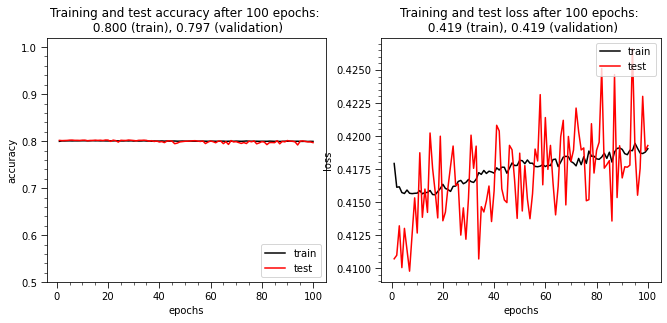

In [24]:
#plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))    

results_dict = neural_model_history.history
epochs = range(1,len(results_dict['accuracy'])+1)

#accuracy
acc_values = results_dict['accuracy']
val_acc_values = results_dict['val_accuracy']
    
axs[0].plot(epochs,acc_values,color='black',label='train',linewidth=1.5,linestyle='-')
axs[0].plot(epochs,val_acc_values,color='red',label='test',linewidth=1.5,linestyle='-')
axs[0].set_xlabel('epochs')
minorLocatorX = AutoMinorLocator()
axs[0].xaxis.set_minor_locator(minorLocatorX)
axs[0].set_ylabel('accuracy')
axs[0].set_ylim([0.5, 1.02])   
minorLocatorY = AutoMinorLocator()
axs[0].yaxis.set_minor_locator(minorLocatorY)
axs[0].tick_params(which='major', length=6)
axs[0].tick_params(which='minor', length=3, color='black')       
axs[0].legend(loc='lower right')
    
#loss
loss_values = results_dict['loss']
val_loss_values = results_dict['val_loss']
       
axs[1].plot(epochs,loss_values,color='black',label='train',linewidth=1.5,linestyle='-')
axs[1].plot(epochs,val_loss_values,color='red',label='test',linewidth=1.5,linestyle='-')
axs[1].set_xlabel('epochs')
minorLocatorX = AutoMinorLocator()
axs[1].xaxis.set_minor_locator(minorLocatorX)   
axs[1].set_ylabel('loss')
minorLocatorY = AutoMinorLocator()
axs[1].yaxis.set_minor_locator(minorLocatorY)
axs[1].tick_params(which='major', length=6)
axs[1].tick_params(which='minor', length=3, color='black')    
axs[1].legend(loc='upper right')

axs[0].set_title('Training and test accuracy after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                 .format(len(epochs),acc_values[-1],val_acc_values[-1]));

axs[1].set_title('Training and test loss after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                 .format(len(epochs),loss_values[-1],val_loss_values[-1]));

In [25]:
ypred2 = neural_model.predict(X_test)
#####
print('Traning and Testing on raw data, all features \n');
#### Model accuracy
# print("Accuracy:", metrics.accuracy_score(y_test, ypred2))

Traning and Testing on raw data, all features 



In [26]:
np.shape(ypred2), np.shape(y_test)

((200000, 1), (200000,))

In [27]:
print("RANDOM FOREST")
print("Accuracy:", metrics.accuracy_score(y_test, ypred.round()))
print("F1:", metrics.f1_score(y_test, ypred.round()))
print("Precision:", metrics.precision_score(y_test, ypred.round()))

print("NEURAL NETWORK")
print("Accuracy:", metrics.accuracy_score(y_test, ypred2.round()))
print("F1:", metrics.f1_score(y_test, ypred2.round()))
print("Precision:", metrics.precision_score(y_test, ypred2.round()))


RANDOM FOREST
Accuracy: 0.76939
F1: 0.6729353699527719
Precision: 0.5716695381872071
NEURAL NETWORK
Accuracy: 0.79663
F1: 0.5923305135709418
Precision: 0.7077096256556415


Confusion matrix, without normalization
[[106430  35551]
 [ 10571  47448]]


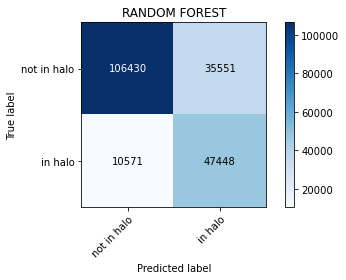

In [30]:
plot_confusion_matrix(y_test, ypred.round(), classes=['not in halo', 'in halo'])
plt.title("RANDOM FOREST")
plt.savefig("confmatrix_randomforest.png")

Confusion matrix, without normalization
[[129777  12204]
 [ 28470  29549]]


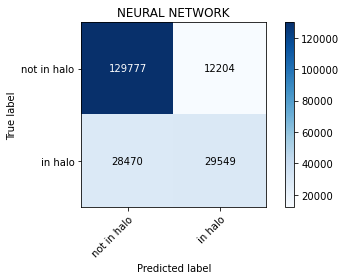

In [31]:
plot_confusion_matrix(y_test, ypred2.round(), classes=['not in halo', 'in halo'])
plt.title("NEURAL NETWORK")
plt.savefig("confmatrix_ann.png")